## Setting Up Environment

 *Used google colab to run this code*

In [1]:
!git clone https://github.com/DumplingCodeEater/SAM-with-BCNN.git

Cloning into 'SAM-with-BCNN'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 40 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 11.23 MiB | 23.18 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
%ls
%cd SAM-with-BCNN

sample_data/  SAM-with-BCNN/  segment-anything-2/
/content/SAM-with-BCNN


In [3]:
!nvidia-smi

Sun Oct 13 15:59:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# To ensure python 3.12 is used (anything over 3.10 is fine in order for SAM2 to run)
# If not using google colab or any other environment that preinstalls latest python
# Creates a `myenv`` virtual environment (as shown in the folder)
# Ex: These are windows commands:
# !py -3.12 -m venv myenv
# !myenv\Scripts\activate
# !py --version

In [5]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content/SAM-with-BCNN


In [6]:
# Installing SAM2 (Reference: https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-images-with-sam-2.ipynb#scrollTo=nx8UNmABNkJP)

# Clone and install SAM2 from Meta's repository
# Might take some time
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 967, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 967 (delta 14), reused 18 (delta 6), pack-reused 936 (from 1)
Receiving objects: 100% (967/967), 128.94 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (331/331), done.
/content/SAM-with-BCNN/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.8 MB/s eta

In [7]:
!pip install -q supervision jupyter_bbox_widget

**NOTE**: SAM2 is available in 4 different model sizes, as imported below

In [8]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

Getting some images for testing

In [9]:
# !mkdir -p {HOME}/data
# !wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
# !wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
# !wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
# !wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

### Importing

In [10]:
# Importing Necessary Modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import random
import cv2
import base64
import supervision as sv

# Importing SAM2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# # Pre-trained Bayesian CNN model for uncertainty estimation
# # Can be fine-tuned with medical data
# from bnn_pytorch import BayesianCNN

# # Dataset Links
# CHEST_XRAY_DATASET_URL = "https://paperswithcode.com/dataset/chestx-ray14"
# BRAIN_MRI_DATASET_URL = "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10584795/"

# For Bayesian layers
from torch.nn.functional import dropout
from torch.distributions import Normal

**NOTE:** This code enables mixed-precision computing for faster deep learning  (bfloat16 and TensorFloat-32 (TF32)).

In [11]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Loading in a SAM2 model
**Note**: Can choose between the 4 models

In [12]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt" # Choosing the large model
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

Tuneable parameters for advanced mask generation:
- `points_per_side` `[int or None]` - the number of points to be sampled
along one side of the image. The total number of points is
`points_per_side**2`. If `None`, `point_grids` must provide explicit
point sampling.
- `points_per_batch` - `[int]` - sets the number of points run simultaneously
by the model. Higher numbers may be faster but use more GPU memory.
- `pred_iou_thresh` `[float]` - a filtering threshold in `[0,1]`, using the
model's predicted mask quality.
- `stability_score_thresh` - `[float]` - a filtering threshold in `[0,1]`, using
the stability of the mask under changes to the cutoff used to binarize
the model's mask predictions.
- `stability_score_offset` - `[float]` - the amount to shift the cutoff when
calculated the stability score.
- `mask_threshold` - `[float]` - threshold for binarizing the mask logits
- `box_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks.
- `crop_n_layers` - `[int]` - if `>0`, mask prediction will be run again on
crops of the image. Sets the number of layers to run, where each
layer has `2**i_layer` number of image crops.
- `crop_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks between different crops.
- `crop_overlap_ratio` - `[float]` - sets the degree to which crops overlap.
In the first crop layer, crops will overlap by this fraction of
the image length. Later layers with more crops scale down this overlap.
- `crop_n_points_downscale_factor` - `[int]` - the number of points-per-side
sampled in layer `n` is scaled down by `crop_n_points_downscale_factor**n`.
- `point_grids` - `[List[np.ndarray] or None]` - a list over explicit grids
of points used for sampling, normalized to `[0,1]`. The nth grid in the
list is used in the nth crop layer. Exclusive with points_per_side.
- `min_mask_region_area` - `[int]` - if `>0`, postprocessing will be applied
to remove disconnected regions and holes in masks with area smaller
than `min_mask_region_area`. Requires opencv.

In [13]:
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

### Testing SAM2 on a single chest image from the chest x-ray dataset

In [15]:
IMAGE_PATH = f"{HOME}/extracted_images/test/00007046_012.png"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

### Output format example

`SAM2AutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [16]:
sam2_result = mask_generator.generate(image_rgb)

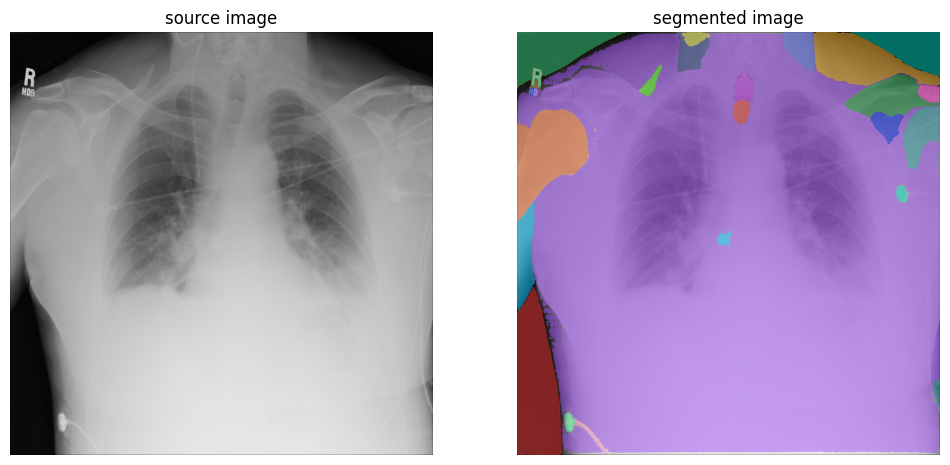

In [17]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

*Note:* this could get better segmentation if using way smaller bounding boxes and ***edge filters*** and/or perform better on some other part of the body like the brain (where parts are bigger in the images to discern)

# Getting Started with the Medical Dataset

In [18]:
# Function to generate and annotate images
def annotate_image(image_path, output_path):
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Generate SAM2 mask results
    sam2_result = mask_generator.generate(image_rgb)

    # Annotate the image with masks
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    detections = sv.Detections.from_sam(sam_result=sam2_result)
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    # Save the annotated image
    cv2.imwrite(output_path, annotated_image)
    print(f"Annotated image saved to {output_path}")

In [ ]:
IMAGE_DIRS = ['test', 'train', 'val']
ANNOTATED_DIR = f"{HOME}/annotated_images"
# Iterate over all images in test, train, and val folders and annotate them
for image_dir in IMAGE_DIRS:
    extracted_dir = os.path.join(HOME, "extracted_images", image_dir)
    annotated_dir = os.path.join(ANNOTATED_DIR, image_dir)

    for image_name in os.listdir(extracted_dir):
        image_path = os.path.join(extracted_dir, image_name)
        output_path = os.path.join(annotated_dir, image_name)

        # Annotate and save the result
        annotate_image(image_path, output_path)

Annotated image saved to /content/SAM-with-BCNN/annotated_images/test/00009218_007.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/test/00008566_005.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/test/00007417_005.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/test/00007046_012.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/test/00007828_000.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/train/00008468_031.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/train/00008067_009.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/train/00008151_001.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/train/00007408_001.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/train/00007245_002.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/train/00006774_007.png
Annotated image saved to /content/SAM

In [ ]:
# Data Preprocessing
class ChestXrayAnnotatedDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        # List of all possible labels, including "No Finding"
        self.labels_list = ["No Finding", "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
                            "Mass", "Nodule", "Pneumonia", "Pneumothorax", "Consolidation",
                            "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        labels = self.dataframe.iloc[idx, 1].split('|')
        label_tensor = torch.zeros(len(self.labels_list))

        # Create one-hot encoding for labels
        if "No Finding" in labels:
            label_tensor[0] = 1  # Set "No Finding" to 1
        else:
            for label in labels:
                if label in self.labels_list:
                    label_tensor[self.labels_list.index(label)] = 1

        if self.transform:
            image = self.transform(image)

        return image, label_tensor


# Model Implementation
class BCNN_Model(nn.Module):
    def __init__(self):
        super(BCNN_Model, self).__init__()
        # Using DenseNet as the CNN backbone
        self.backbone = models.densenet121(pretrained=True)
        self.backbone.classifier = nn.Identity()

        # Bayesian layers
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 2)  # Binary classification (Disease vs No Disease)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Uncertainty Estimation using Monte Carlo Dropout
def mc_dropout(model, images, n_samples=100):
    model.train()  # Enable dropout at inference
    preds = [model(images) for _ in range(n_samples)]
    return torch.stack(preds).mean(0), torch.stack(preds).std(0)

# Training Loop
def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

    return model

# Evaluation Metrics
def evaluate_model(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            preds = model(inputs)
            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc_roc = roc_auc_score(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}")

# Initialize and train the model
model = BCNN_Model()
trained_model = train_model(model, train_loader, val_loader)

# Evaluate the trained model
evaluate_model(trained_model, val_loader)

# Uncertainty Estimation on test data
images, _ = next(iter(val_loader))
mean_preds, uncertainty = mc_dropout(trained_model, images)
print(f"Mean predictions: {mean_preds}, Uncertainty: {uncertainty}")

Citations:
```
@inproceedings{Wang_2017,
	doi = {10.1109/cvpr.2017.369},
	url = {https://doi.org/10.1109%2Fcvpr.2017.369},
	year = 2017,
	month = {jul},
	publisher = {{IEEE}
},
	author = {Xiaosong Wang and Yifan Peng and Le Lu and Zhiyong Lu and Mohammadhadi Bagheri and Ronald M. Summers},
	title = {{ChestX}-Ray8: Hospital-Scale Chest X-Ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases},
	booktitle = {2017 {IEEE} Conference on Computer Vision and Pattern Recognition ({CVPR})}
}
```